# Лабораторная работа №5.3.3
### "Определение энергии $\gamma$-квантов с помощью сцинтилляционного спектрометра"

В данной работе определяется энергия $\gamma$-квантов неизвестного радиоактивного препарата после предварительной калибровки спектрометра по $\gamma$-излучению $^{60}\mathrm{Co}$.

#### Градуировка

In [58]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [59]:
df = pd.read_csv('data.csv', na_values=0).fillna(0)

In [60]:
df.head()

,LL,N,NN,N_1,NN_1
0,3.0,214.0,0.0,436.0,431.0
1,3.1,210.0,0.0,417.0,0.0
2,3.2,207.0,0.0,326.0,0.0
3,3.3,219.0,0.0,253.0,276.0
4,3.4,181.0,0.0,249.0,0.0


Поскольку в последние 5 минут было решено сделать доп. измерениия на _пониженном_ пороге, отсортируем по $LL$

In [61]:
df = df.sort_values('LL')

In [62]:
df.head()

,LL,N,NN,N_1,NN_1
77,2.2,0.0,0.0,511.0,0.0
76,2.3,0.0,0.0,484.0,0.0
75,2.4,0.0,0.0,488.0,0.0
74,2.5,0.0,0.0,505.0,0.0
73,2.6,0.0,0.0,496.0,0.0


Посмотрим, что из себя представляют данные

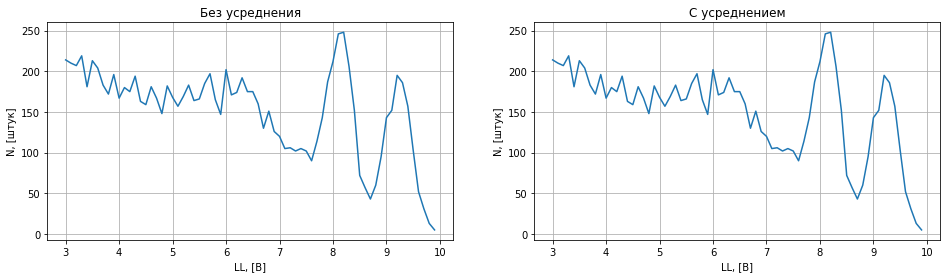

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Уберем пропуски в `N` (нули)
plot_data = df[df['N'] != 0]
# Иногда я делал два измерения. В результирующий график уйдет их среднее
axes[0].plot(plot_data['LL'], plot_data['N'])
axes[0].set_title(r'Без усреднения')
# Сравним два вида!
tmp = plot_data.loc[plot_data['NN'] != 0]
plot_data.loc[plot_data['N'] != 0]['N'] = 0.5*(tmp['N'] + tmp['NN'])
del tmp


axes[1].plot(plot_data['LL'], plot_data['N'])
axes[1].set_title(r'С усреднением')

for ax in axes:
    ax.set_xlabel(r'LL, [В]')
    ax.set_ylabel(r'N, [штук]')
    ax.grid()
# NOTE: Теперь plot_data УСРЕДНЕНА по N

Теперь нам надо как-то выделить пики. Попробуем несколько способов аппроксимации.

Для начала выделим **функции**, которыми будем аппроксимировать.

In [64]:
from scipy.optimize import curve_fit

# Видно, что у нас будут пологие и пиковые участки
# Для каждого из них мы определим свою функцию
# Пологие
plain_functions = [
    lambda x, a, b: a*x+b,  # Линейная
    lambda x, a, b: a/x+b,   # Гипербола
]
# Пики
from scipy.stats import norm
peak_functions = [
    lambda x, a, b, c: a*x**2 + b*x + c,   # Парабола
    lambda x, mu, sigma: norm(loc=mu, scale=sigma).pdf(x)
]

In [65]:
# Теперь сама аппроксимация
# Я немного захардкодю точки перемены монотонности. Не бейте за это!
x_1, x_2, x_3 = 7.5, 8.8, 10
plain_data = plot_data.loc[plot_data['LL'] < x_1]
peak1_data = plot_data.loc[(x_1 <= plot_data['LL']) & (plot_data['LL'] < x_2)]
peak2_data = plot_data.loc[(x_2 < plot_data['LL']) & (plot_data['LL'] < x_3)]

Мы будем отбирать из функций те, что дадут меньшую погрешность!

In [66]:
# For plain area
def find_optimal_function(data, functions, y_data='N'):
    opt_func = functions[0]
    opt_param = []
    prev_err = np.inf
    for func in functions:
        popt, pcov = curve_fit(func, data['LL'], data[y_data])
        perr = np.sqrt(np.diag(pcov))[0]
        if perr < prev_err:
            opt_func = func
            opt_param = popt
    print(opt_param)
    return lambda x: opt_func(x, *opt_param)

plain_opt_func = find_optimal_function(plain_data, plain_functions)
# НЕ РАБОТАЕТ
#peak1_opt_func = find_optimal_function(peak1_data, peak_functions)
#peak2_opt_func = find_optimal_function(peak2_data, peak_functions)

[380.12269339  90.85918011]


In [67]:
peak1_opt_func = lambda x, a, b: a*norm(loc=8.15, scale=0.3).pdf(x) + b
peak2_opt_func = lambda x, a, b: a*norm(loc=9.25, scale=0.3).pdf(x) + b

def optimize_norm_function(norm_function, x_data, y_data):
    popt, pcov = curve_fit(norm_function, x_data, y_data)
    return lambda x: norm_function(x, *popt)

peak1_opt_func = optimize_norm_function(peak1_opt_func, peak1_data['LL'], peak1_data['N'])
peak2_opt_func = optimize_norm_function(peak2_opt_func, peak2_data['LL'], peak2_data['N'])

Нарисуем оптимальные функции

/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


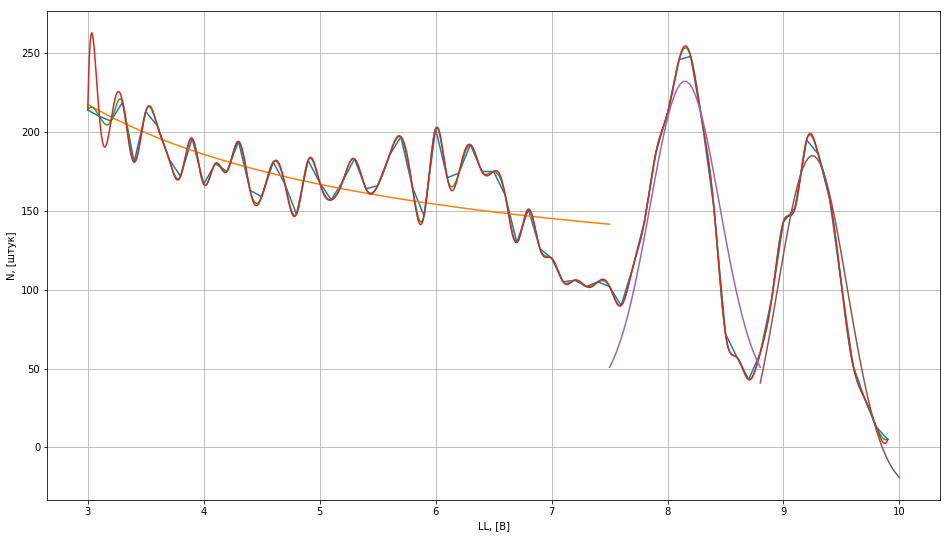

In [68]:
fig, ax = plt.subplots(figsize=(16, 9))

plain_range = np.linspace(plot_data['LL'].min(), x_1)
peak1_range = np.linspace(x_1, x_2)
peak2_range = np.linspace(x_2, x_3)

ax.plot(plot_data['LL'], plot_data['N'])
ax.plot(plain_range, plain_opt_func(plain_range))
# Сделаем еще интерполяцию сплайнами
from scipy.interpolate import interp1d, spline
# Интерполяция
ax.plot(np.linspace(3, 9.9, 1000), interp1d(plot_data['LL'], plot_data['N'], kind='cubic')(np.linspace(3, 9.9, 1000)))
# Сплайны
ax.plot(np.linspace(3, 9.9, 1000), spline(plot_data['LL'], plot_data['N'], np.linspace(3, 9.9, 1000), order=5))
ax.plot(peak1_range, peak1_opt_func(peak1_range))
ax.plot(peak2_range, peak2_opt_func(peak2_range))

ax.set_xlabel(r'LL, [В]')
ax.set_ylabel(r'N, [штук]')
ax.grid()

fig.show()

Выглядит _ОЧЕНЬ_ страшно. Но ничего! Отсюда мы имеем максимумы!

$$\boxed{a_1 = 8.15 \text{, [B]}\\
a_2 = 9.25 \text{, [B]}}$$

Отсюда мы имеем ДЕРЬМО!

Давайте теперь переведем их в энергии. Согласно лабнику, этим максимумам соответствуют энергии
$$\boxed{
E_1 = 1.17,\,\text{[МэВ]} \\ 
E_2 = 1.33,\,\text{[МэВ]}
}$$
Проверим отношение $\dfrac{E_1}{E_2} / \left(\dfrac{a_1}{a_2}\right) = 1$. После подстановки на калькуляторе имеем $0.99$ вместо $1$ - хорошая точность!

In [41]:
a_1, a_2, E_1, E_2 = 8.15, 9.25, 1.17, 1.33

#### Неизвестное вещество

Построим аналогичный график для неизвестного вещества

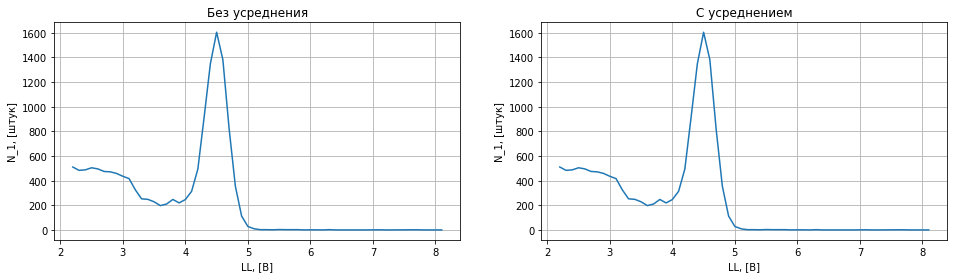

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Уберем пропуски в `N_1` (нули)
plot_data = df[df['N_1'] != 0]
# Иногда я делал два измерения. В результирующий график уйдет их среднее
axes[0].plot(plot_data['LL'], plot_data['N_1'])
axes[0].set_title(r'Без усреднения')
# Сравним два вида!
tmp = plot_data.loc[plot_data['NN_1'] != 0]
plot_data.loc[plot_data['N_1'] != 0]['N_1'] = 0.5*(tmp['N_1'] + tmp['NN_1'])
del tmp


axes[1].plot(plot_data['LL'], plot_data['N_1'])
axes[1].set_title(r'С усреднением')

for ax in axes:
    ax.set_xlabel(r'LL, [В]')
    ax.set_ylabel(r'N_1, [штук]')
    ax.grid()
# NOTE: Теперь plot_data УСРЕДНЕНА по N

Найдем максимум и попробуем аппроксимировать на разных участках

In [43]:
# Теперь сама аппроксимация
# Я немного захардкодю точки перемены монотонности. Не бейте за это!
x_1, x_2= 4, 4.9
plain_data = plot_data.loc[plot_data['LL'] < x_1]
peak1_data = plot_data.loc[(x_1 <= plot_data['LL']) & (plot_data['LL'] < x_2)]

In [44]:
LL_max = plot_data['LL'][np.argmax(plot_data['N_1'])]

/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [45]:
print(LL_max)

4.5


In [46]:
plain_opt_func = find_optimal_function(plain_data, plain_functions, y_data="N_1")

peak1_opt_func = lambda x, a, b: a*norm(loc=LL_max, scale=LL_max*0.3).pdf(x) + b

def optimize_norm_function(norm_function, x_data, y_data):
    popt, pcov = curve_fit(norm_function, x_data, y_data)
    return lambda x: norm_function(x, *popt)

peak1_opt_func = optimize_norm_function(peak1_opt_func, peak1_data['LL'], peak1_data['N_1'])

[1820.79514625 -244.26615754]


Нарисуем оптимальные функции

/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  del sys.path[0]
/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


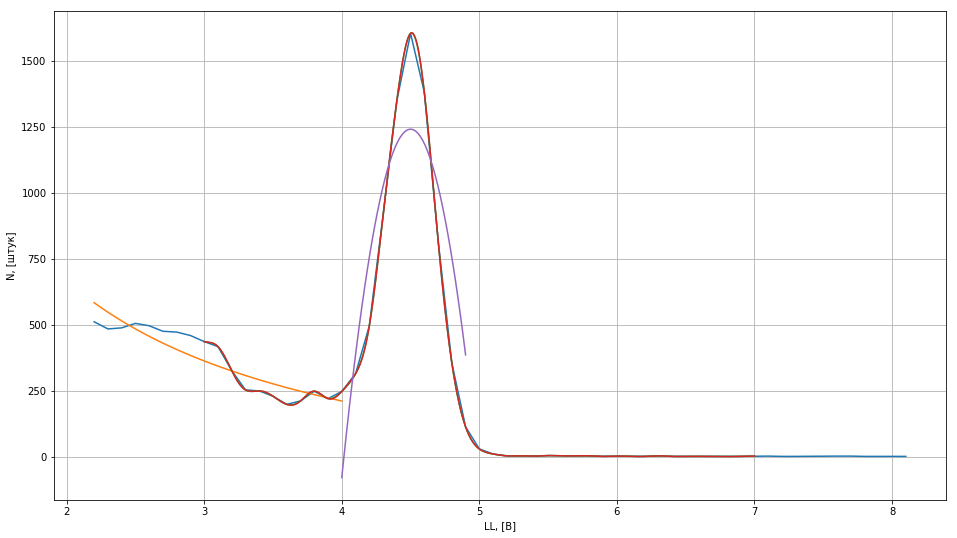

In [56]:
fig, ax = plt.subplots(figsize=(16, 9))

plain_range = np.linspace(plot_data['LL'].min(), x_1)
peak1_range = np.linspace(x_1, x_2)

ax.plot(plot_data['LL'], plot_data['N_1'])
ax.plot(plain_range, plain_opt_func(plain_range))
# Сделаем еще интерполяцию сплайнами
from scipy.interpolate import interp1d, spline
# Интерполяция
ax.plot(np.linspace(3, 7, 1000), interp1d(plot_data['LL'], plot_data['N_1'], kind='cubic')(np.linspace(3, 7, 1000)))
# Сплайны
ax.plot(np.linspace(3, 7, 1000), spline(plot_data['LL'], plot_data['N_1'], np.linspace(3, 7, 1000), order=5))
ax.plot(peak1_range, peak1_opt_func(peak1_range))

ax.set_xlabel(r'LL, [В]')
ax.set_ylabel(r'N, [штук]')
ax.grid()

fig.show()

Видно, что этот пик приходится на $\boxed{a_3 = 4.5,\,\text{[В]}}$. Отсюда можно пересчитать энергию через МНК-кривую, проведенную по двум точкам

In [49]:
a_3 = 4.5

In [50]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)

model.fit(np.array([a_1, a_2]).reshape(-1, 1), np.array([E_1, E_2]))
E_3 = model.predict(np.array([a_3]).reshape(-1, 1))[0]
print(E_3)

0.6465835444287266


Итак, искомая энергия равна
$$\boxed{
E_3 = 0.64,\, \text{[МэВ]}
}$$

Оценим энерегетическое разрешение спектрометра по формуле: $R = \dfrac{\delta}{E} \cdot 100 \%$, $\delta$ - ширина пика полного поглощения, измеренная на половине высоты (в единицах энергии).

In [51]:
threshold = 1/2*(np.max(plot_data['N_1']) + np.min(plot_data['N_1']))

In [52]:
tmp = plot_data[plot_data['N_1'] > threshold]
delta = np.max(tmp['LL']) - np.min(tmp['LL'])

In [53]:
R = delta / E_3 * 100
print(R)

61.863622024809


Итак, $\boxed{
R = 62
}$